# TLdetect

An implementation of a convolutional neural network to detect the state of traffic lights in images. The states are red, green, yellow and no traffic light. Using the **tensorflow** framework.

### Importing packages

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
from scipy import misc

In [ ]:
# TODO - Improve this cell. Always extracting, even if the folder exists
# Extracting the dataset
import tarfile
with tarfile.open('data/object-dataset.tar.gz', "r:gz") as file:
    file.extractall('data')

### Pre-processing

Loading the images and labels and treating the dataset to fit better on our model. Note that the images won't be loaded right now, only their file names, in order to save memory and avoid bottlenecks and errors.

In [8]:
# Loading the labels
header = ['File', 'x_min', 'y_min', 'x_max', 'y_max', 'occluded', 'label', 'properties']
raw_labels = pd.read_csv('data/object-dataset/labels.csv', 
                         sep=' ', header=None, names=header)

# Extracting just the labels with traffic lights
tl_labels = raw_labels[raw_labels['label'] == 'trafficLight']

# At this moment, the conv net will only classify if an image has or not a traffic light.
# So, duplicates are not desired.
tl_labels = tl_labels.drop_duplicates('File')

In [9]:
# Loading the images. In reality, just their names
raw_files = pd.DataFrame(os.listdir('data/object-dataset/'), columns=['File'])
images = raw_files[raw_files['File'] != 'labels.csv']

# Dividing the datasets
num_images = len(images)

# Training and Validation images
indexes = random.sample(set(images.index.values[:-1]), int(num_images * 0.85))
validation_indexes = random.sample(set(indexes), int(len(indexes) * 0.15))
train_indexes = list(set(indexes) - set(validation_indexes))

X_train = images.get_values()[train_indexes]
X_valid = images.get_values()[validation_indexes]

# Test images
test_indexes = list(set(images.index.values[:-1]) - set(indexes))
X_test = images.get_values()[test_indexes]

# Debug
print("Train: %d" % len(X_train))
print("Validation: %d" % len(X_valid))
print("Test: %d" % len(X_test))

Train: 10839
Validation: 1912
Test: 2250


In [10]:
# Generating the labels
#TODO : Improve this thing. Bad performance
#       Only the train labels are selected
Y_train = []
for label in X_train:
    result = [1, 0] if label in tl_labels.File.values else [0, 1]
    Y_train.append(result)

### Creating the model

At the following cells we will define our model. Our model, at this moment, will just classify if a given image has a traffic light or not.

#### The following architecture will be used:
1. **Convolutional layer**
+ **Pooling layer**
+ **Convulutional layer**
+ **Pooling layer**
+ **Affine layer**
+ **Classification**

**Defining useful functions**

In [11]:
def convolution(inputs, W, stride=(1, 1, 1, 1), padding='SAME'):
    """
        Given inputs and weights, applies a convolution to the images.
        Note:
            inputs has the shape (N, H, W, C)
            and weights has the shape (H, W, C, K)
            where:
            N = Number of inputs
            H = Height
            W = Width
            C = Channel
            K = Number of kernels
    """
    return tf.nn.conv2d(inputs, W, strides=stride, padding=padding)

def max_pooling(inputs, window_size=(1, 2, 2, 1), stride=(1, 2, 2, 1),
                padding='SAME'):
    """
        Applies a 2x2 max-pooling in a given image. Reduces the resolution.
    """
    return tf.nn.max_pool(inputs, ksize=window_size, strides=stride,
                          padding=padding)

**Defining hyperparameters, weights and biases**

In [12]:
# TODO: Improve the implementation. The model is fitted only for one type. Generalize more.

# Defining inputs
X = tf.placeholder(tf.float32, shape=[None, 1200, 1920, 3])
Y = tf.placeholder(tf.float32, shape=[None, 2])
# Parameters
conv_0_params = {}
conv_1_params = {}
fc_0_params = {}
fc_1_params = {}
conv_0_params['W'] = tf.Variable(tf.random_normal((3, 3, 3, 4), mean=0, stddev=1e-2),
                        dtype=tf.float32)
conv_0_params['b'] = tf.Variable(tf.zeros(4))

conv_1_params['W'] = tf.Variable(tf.random_normal((3, 3, 4, 4), mean=0, stddev=1e-2),
                        dtype=tf.float32)
conv_1_params['b'] = tf.Variable(tf.zeros(4))

fc_0_params['W'] = tf.Variable(tf.random_normal((300*480*4, 100), mean=0, stddev=1e-2),
                        dtype=tf.float32)
fc_0_params['b'] = tf.Variable(tf.zeros(100))

fc_1_params['W'] = tf.Variable(tf.random_normal((100, 2), mean=0, stddev=1e-2),
                        dtype=tf.float32)
fc_1_params['b'] = tf.Variable(tf.zeros(2))

**Defining the architecture itself**

In [13]:
# Defining the architecture
conv_0 = tf.nn.relu(convolution(X, conv_0_params['W']) + conv_0_params['b'])
pool_0 = max_pooling(conv_0)
conv_1 = tf.nn.relu(convolution(pool_0, conv_1_params['W']) + conv_1_params['b'])
pool_1 = max_pooling(conv_1)

reshaped_X = tf.reshape(pool_1, [-1, 300 * 480 * 4])
fc_layer_0 = tf.nn.relu(tf.matmul(reshaped_X, fc_0_params['W']) + fc_0_params['b'])
fc_layer_1 = tf.matmul(fc_layer_0, fc_1_params['W']) + fc_1_params['b']

**Selecting the data to be used for training**

In [14]:
Images = []
for i in range(2):
    Images.append(misc.imread('data/object-dataset/' + X_train.item(i)))

**Training the model**

In [15]:
sess = tf.Session()

# Defining the loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=fc_layer_1))

training_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)
prediction_test = tf.equal(tf.argmax(fc_layer_1,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(prediction_test, tf.float32))

sess.run(tf.global_variables_initializer())

In [19]:
# TODO: Accuracy not being measured as should be.
#       Beyond that, put everything in half-precision to save memory

# Effectively training
with sess.as_default():
    for iteration in range(100):
        if not (iteration % 10):
            loss_value = loss.eval(feed_dict={Y:Y_train[:2], X:Images})
            print("Loss: %f" % loss_value)
        if not (iteration % 50):
            acc = accuracy.eval(feed_dict={Y:Y_train[:2], X:Images})
            print("Iteration: %d, Accuracy: %f" % (iteration, acc))
        training_step.run(feed_dict={Y:Y_train[:2], X:Images})

Loss: 0.000601
Iteration: 0.000000, Accuracy: 1.000000
Loss: 0.000299
Loss: 0.000153
Loss: 0.000080
Loss: 0.000042
Loss: 0.000022
Iteration: 50.000000, Accuracy: 1.000000
Loss: 0.000012
Loss: 0.000007
Loss: 0.000004
Loss: 0.000002


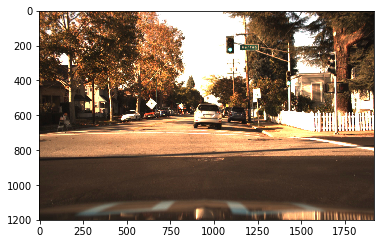

In [23]:
import matplotlib.pyplot as plt
plt.imshow(Images[0])
plt.show()